<a href="https://colab.research.google.com/github/govindramesh/segment-anything/blob/main/notebooks/Fine_Tuning_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install torch torchvision torchmetrics &> /dev/null
! pip install opencv-python pycocotools matplotlib onnxruntime onnx &> /dev/null
! pip install git+https://github.com/facebookresearch/segment-anything.git &> /dev/null
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth &> /dev/null

In [14]:
pip show torch

Name: torch
Version: 2.0.1+cu118
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, jinja2, networkx, sympy, triton, typing-extensions
Required-by: fastai, torchaudio, torchdata, torchmetrics, torchtext, torchvision, triton


In [32]:
%load_ext autoreload
%autoreload 2

In [33]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

[autoreload of segment_anything.predictor failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: set_torch_image() requires a code object 

In [27]:
from segment_anything import SamPredictor, sam_model_registry
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch
import os

In [28]:

checkpoint = 'sam_vit_b_01ec64.pth'
sam = sam_model_registry['vit_b'](checkpoint=checkpoint)
predictor = SamPredictor(sam)


In [18]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, mask_dir, transform=None, transform_mask=None):
        self.root_dir = root_dir
        self.mask_dir = mask_dir
        self.transform = None#predictor.transform
        self.transform_mask = transform_mask
        self.images = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.images[idx])
        mask_name = os.path.join(self.mask_dir, self.images[idx][:3]+"_label.PNG")

        image = np.asarray(Image.open(img_name))
        mask = np.asarray(Image.open(mask_name))

        if self.transform:
            image = self.transform.apply_image(image)
            mask = self.transform_mask(mask)
            #print("Mask worked")

        return image, mask

In [6]:
transform = transforms.Compose([
    #transforms.Resize((224, 224)), # Resize to the size a model expects
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalization values for pre-trained PyTorch models
])

transform_mask = transforms.Compose([
    #transforms.Resize((224, 224)), # Resize to the size a model expects
    transforms.ToTensor()])

In [29]:
# Load custom dataset
dataset = CustomDataset(root_dir='/content/Images', mask_dir='/content/Masks', transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predictor.model.to(device)
predictor.model.train()

In [21]:
from torchmetrics import Dice
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([60]).to(device))
#criterion = Dice().to("cuda")

optimizer = torch.optim.SGD(predictor.model.mask_decoder.parameters(), lr=.1, momentum=0.9)


In [22]:
from tqdm import tqdm

In [23]:
for name, param in predictor.model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
    print(name)
  else:
    param.requires_grad_(True)

prompt_encoder.point_embeddings.0.weight
prompt_encoder.point_embeddings.1.weight
prompt_encoder.point_embeddings.2.weight
prompt_encoder.point_embeddings.3.weight
prompt_encoder.not_a_point_embed.weight
prompt_encoder.mask_downscaling.0.weight
prompt_encoder.mask_downscaling.0.bias
prompt_encoder.mask_downscaling.1.weight
prompt_encoder.mask_downscaling.1.bias
prompt_encoder.mask_downscaling.3.weight
prompt_encoder.mask_downscaling.3.bias
prompt_encoder.mask_downscaling.4.weight
prompt_encoder.mask_downscaling.4.bias
prompt_encoder.mask_downscaling.6.weight
prompt_encoder.mask_downscaling.6.bias
prompt_encoder.no_mask_embed.weight


In [24]:
def hook(module, grad_input, grad_output):
  print(grad_input, grad_output)

predictor.model.mask_decoder.register_full_backward_hook(hook)

In [31]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader, 0)):
        inputs, labels = data
        labels = labels.to(device)/255

        inputs = inputs.to(device)
        #batched_input = [{"image":image, "original_size":(320,480)} for image in inputs]
        #print(batched_input[0]["image"].shape)
        #print(labels.shape)
        #print(inputs[0].shape)
        optimizer.zero_grad()
        #torch.set_grad_enabled(True)
        #outputs = sam(inputs, False)
        #batched_outputs = predictor.model(batched_input, False)
        batch_masks = []
        for image in inputs:
          #print(type(image))
          predictor.set_image(np.asarray(image.cpu()))
          masks, scores, logits = predictor.predict(
              #point_coords=input_point,
              #point_labels=input_label,
              multimask_output=False,
              return_logits=True
          )
          #print(masks.shape)
          batch_masks.append(masks[0])
        #outputs = torch.cat([x["masks"].to(torch.float32) for x in batched_outputs],0)
        #outputs = torch.cat([x["masks"].long() for x in batched_outputs],0)
        #print(outputs.shape)
        #print(batch_masks[0].shape)
        outputs = torch.Tensor(np.array(batch_masks)).to(device)
        outputs.requires_grad_(True)
        #print(outputs.shape, labels.shape)
        #print([x.flatten().sum().item() for x in labels])

        loss = criterion(outputs, labels.float())
        loss.requires_grad_(True)
        loss.backward()
        optimizer.step()
        #print(list(predictor.model.mask_decoder.parameters())[0].grad)

        running_loss += loss.item()
        #print(i, loss.item())
        #running_loss = 0.0
    print(f"EPOCH LOSS: {running_loss/29}")
print('Finished Training')

30it [00:52,  1.74s/it]


EPOCH LOSS: 1.4526597487515416


26it [00:45,  1.75s/it]


KeyboardInterrupt: ignored

In [ ]:
#print(predictor.model.mask_decoder.parameters)
params2 = []
weights = list(predictor.model.mask_decoder.parameters())[0].clone().detach().numpy()
#print(weights[0])
#for param in weights:
 #   params2.append()
params2 = torch.Tensor(weights)
print(params2.shape)
params2[0]

In [ ]:
torch.sub(params, params2).flatten().sum()

In [ ]:
#print(predictor.model.mask_decoder.parameters)
params = []
for param in predictor.model.mask_decoder.parameters():
    params.append(param.view(-1))
params = torch.cat(params)
print(params.shape)
params[0:1000]

torch.Size([4058340])


tensor([-1.8474e-02, -1.5033e-02, -5.1953e-02, -5.5395e-02, -1.0774e-03,
         5.2961e-02,  2.8449e-02,  3.4338e-02,  2.1717e-02,  4.4031e-02,
         3.9403e-02,  5.0018e-02, -3.2629e-02,  2.5006e-02, -4.2595e-02,
         9.4043e-03, -3.8798e-02, -3.5383e-02, -6.2781e-02, -3.4302e-02,
        -1.8417e-02, -4.7488e-03,  5.1828e-02,  5.3654e-03, -1.2537e-02,
         6.4473e-03,  1.7436e-02, -1.1065e-02, -2.1379e-02,  4.7979e-02,
         1.2693e-02, -1.2510e-02,  1.2868e-02,  5.7113e-03, -3.3316e-02,
         1.6177e-02,  2.4091e-02, -3.9229e-02,  1.3001e-02,  1.8300e-03,
         1.0618e-02,  3.5862e-03, -4.0558e-03,  2.0214e-02,  8.5732e-03,
         3.6868e-02, -2.4762e-03,  2.5129e-02, -4.1227e-02,  4.6677e-02,
         1.0070e-02, -2.3310e-03, -1.1407e-01, -3.5559e-02,  9.7979e-03,
         5.8653e-02,  7.1390e-02, -1.9813e-02, -1.0116e-01,  3.4330e-03,
        -3.6978e-02, -3.0122e-02, -2.8661e-02,  1.7570e-02,  2.8245e-02,
        -2.9745e-02, -5.2981e-03,  4.6202e-02,  2.9

-0.5040979
0.39559448 -1.9155644


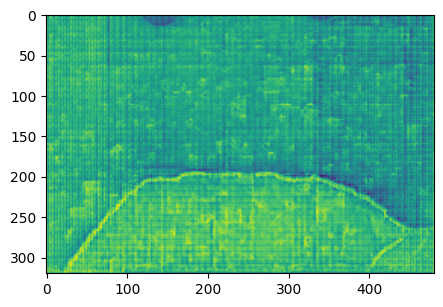

In [ ]:
plt.figure(figsize=(5,5))
output = np.asarray(outputs[0].cpu())
#output = dataset.__getitem__(117)[0]
print(np.mean(output))
temp = output# - output.min()
print(temp.max(), temp.min())
plt.imshow(temp)

-0.5040979
0.39559448 -1.9155644


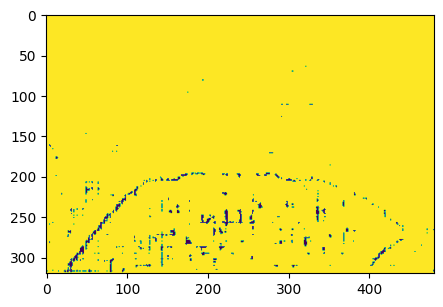

In [ ]:
plt.figure(figsize=(5,5))
output = np.asarray(outputs[0].cpu())
#output = dataset.__getitem__(117)[0]
print(np.mean(output))
temp = output# - output.min()
print(temp.max(), temp.min())
plt.imshow(ma.masked_less(temp, 0).mask.astype(int))


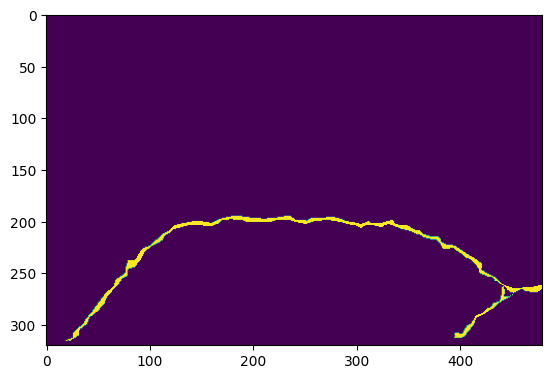

In [ ]:
plt.imshow(np.asarray(labels[0].cpu())/255)
#plt.imshow(dataset.__getitem__(0)[1])

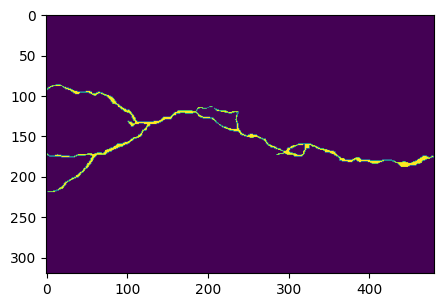

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(labels[0].cpu())

In [ ]:
labels[0,0,:,:].flatten().sum().item()

2799.0

In [ ]:
image = transform(Image.open('/content/soccer_image.jpeg')).to("cuda")
test_input = [{"image":image, "point_coords":torch.Tensor([[[1000,900]]]).to('cuda'), "point_labels":torch.Tensor([[1]]).to('cuda'), "original_size":(1564,2500)}]
predictor.model.mask_threshold = 0
test_output = predictor.model(test_input, False)
#print(len(test_output))
mask = test_output[0]['masks'][0,0,:,:].double().cpu()
print(test_output[0]['iou_predictions'])
logits = test_output[0]['low_res_logits'][0,0,:,:].cpu()
#print(mask.flatten().sum().item())
#print(len(mask.flatten()))
print(mask)
#mask = labels[0,0,:,:].long().cpu()
#masks = predictor.model.postprocess_masks(logits, (256,256), (1564,2500))[0,0,:,:].cpu()
plt.figure(figsize=(5,5))
plt.imshow(mask)

FileNotFoundError: ignored

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs = data.to(device)
        batched_input = [{"image":image, "original_size":(224,224)} for image in inputs]
        print(batched_input[0]["image"].shape)
        optimizer.zero_grad()

        batched_outputs = sam(batched_input, False)
        outputs = torch.cat([x["masks"].to(torch.float32) for x in batched_outputs],0)
        print(outputs.shape)
        print(inputs.shape)
        print(len(batched_outputs), type(inputs[0]))
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

# Huggingface Version

In [ ]:
!pip install -q monai
!pip install -q git+https://github.com/huggingface/transformers.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.6 MB/s eta 0:00:00


In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, mask_dir):
        self.root_dir = root_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.images[idx])
        mask_name = os.path.join(self.mask_dir, self.images[idx][:3]+"_label.PNG")

        image = np.asarray(Image.open(img_name)).transpose(2, 0, 1)
        mask = np.asarray(Image.open(mask_name))

        return image, mask

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, root_dir, mask_dir, processor):
    self.processor = processor
    self.root_dir = root_dir
    self.mask_dir = mask_dir
    self.images = os.listdir(self.root_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = Image.open(os.path.join(self.root_dir, self.images[idx]))
    ground_truth_mask = Image.open(os.path.join(self.mask_dir, self.images[idx][:3]+"_label.PNG"))

    # prepare image and prompt for the model
    inputs = self.processor(image, return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = np.array(ground_truth_mask.resize((256,256)))

    return inputs

In [ ]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [ ]:
from torch.utils.data import DataLoader

# Load custom dataset
#dataset = CustomDataset(root_dir='/content/Images', mask_dir='/content/Masks')
dataset = SAMDataset(root_dir='/content/Images', mask_dir='/content/Masks', processor=processor)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
example = dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
ground_truth_mask (256, 256)


In [ ]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [ ]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=.01, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([60]).to(device))


In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      print(predicted_masks.flatten().min(), predicted_masks.flatten().max())
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

In [ ]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = 10

# load image
image = torch.unsqueeze(dataset[idx]["pixel_values"],0)
image

tensor([[[[0.5707, 0.5878, 0.6221,  ..., 0.2453, 0.3481, 0.3823],
          [0.6221, 0.6392, 0.6392,  ..., 0.2453, 0.3994, 0.4679],
          [0.7591, 0.7419, 0.7077,  ..., 0.2282, 0.5364, 0.6734],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.6429, 0.6604, 0.6954,  ..., 0.3627, 0.4678, 0.5028],
          [0.6954, 0.7129, 0.7129,  ..., 0.3627, 0.5203, 0.5903],
          [0.8354, 0.8179, 0.7829,  ..., 0.3452, 0.6604, 0.8004],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.8099, 0.8274, 0.8622,  ..., 0.4962, 0.6008, 0.6356],
          [0.8622, 0.8797, 0.8797,  ..., 0.4962, 0.6531, 0.7228],
          [1.0017, 0.9842, 0.9494,  ..., 0

In [ ]:
with torch.no_grad():
  output = model(pixel_values=image.to(device),
                        multimask_output=False)
output = output.pred_masks.squeeze().cpu()

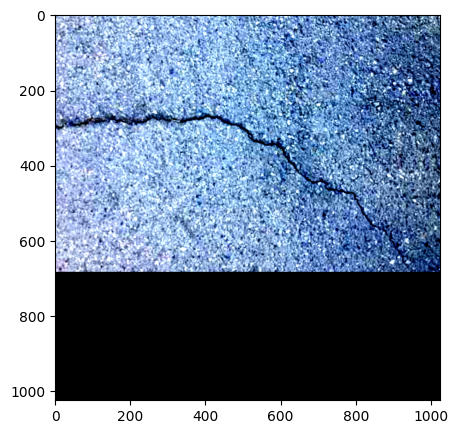

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(image.squeeze().permute(1, 2, 0))

tensor(7.5686e+09) tensor(7.5686e+09)


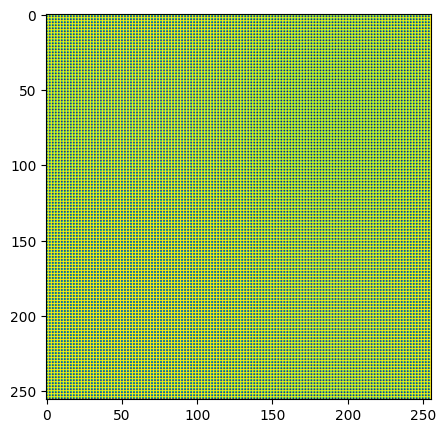

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(output)
print(output[100][100], output[0][0])

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader, 0)):
        inputs, labels = data
        labels = labels.to(device)/255

        inputs = inputs.to(device)
        optimizer.zero_grad()

        batch_masks = []
        for image in inputs:
          predictor.set_image(np.asarray(image.cpu()))
          masks, scores, logits = predictor.predict(
              multimask_output=False,
              return_logits=True
          )
          batch_masks.append(masks[0])

        outputs = torch.Tensor(np.array(batch_masks)).to(device)

        loss = criterion(outputs, labels.float())
        loss.requires_grad = True
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"EPOCH LOSS: {running_loss/29}")
print('Finished Training')